In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/DS_2019_public.csv', encoding='ISO-8859-1')

<ipython-input-3-23ea9327a976>:1: DtypeWarning: Columns (30,56,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Datasets/DS_2019_public.csv', encoding='ISO-8859-1')


In [4]:
for col in data.columns:
    if data[col].dtype == 'object':
        for val in data[col]:
            if isinstance(val, str) and not val.isnumeric():
                print(f"Column {col} contains non-numeric values")
                break

Column DOLELCOL contains non-numeric values
Column DOLFOSPH contains non-numeric values
Column DOLELSPH contains non-numeric values
Column DOLNGWTH contains non-numeric values
Column CUFEETNGOTH contains non-numeric values
Column KWHOTH contains non-numeric values
Column CUFEETNGWTH contains non-numeric values
Column DOLELRFG contains non-numeric values


In [5]:
numeric_cols = data.select_dtypes(include='number').columns

In [6]:
data = data[numeric_cols]
data = data.dropna()

In [7]:
target = 'TOTALDOL'

In [8]:
X = data.drop(target, axis=1)
y = data[target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [11]:
def train_regression_model(layers, activations, optimizer):
    model = Sequential()
    for i, (layer, activation) in enumerate(zip(layers, activations)):
        if i == 0:
            model.add(Dense(layer, activation=activation, input_dim=X_train.shape[1]))
        else:
            model.add(Dense(layer, activation=activation))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mse')

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, 
                        validation_data=(X_val, y_val), callbacks=
                        [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    return model, history

In [12]:
layer_options = [[16, 8], [32, 16], [64, 32]]
activation_options = [['relu', 'relu'], ['tanh', 'tanh'], ['relu', 'tanh']]
optimizer_options = ['adam', 'rmsprop', 'sgd']

In [13]:
regression_results = []

for layers in layer_options:
    for activations in activation_options:
        for optimizer in optimizer_options:
            model, history = train_regression_model(layers, activations, optimizer)
            y_pred = model.predict(X_test).flatten()

            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            regression_results.append({
                'layers': layers,
                'activations': activations,
                'optimizer': optimizer,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'model': model,
                'history': history
            })

68/68 [==============================] - 0s 1ms/step


In [14]:
best_regressor = max(regression_results, key=lambda x: x['r2'])
print(f"The best regressor: layers {best_regressor['layers']}, activations {best_regressor['activations']}, optimizer {best_regressor['optimizer']}")
print(f"MSE: {best_regressor['mse']}")
print(f"MAE: {best_regressor['mae']}")
print(f"R2: {best_regressor['r2']}")

The best regressor: layers [64, 32], activations ['relu', 'relu'], optimizer rmsprop
MSE: 41587.937964993675
MAE: 124.10324236990391
R2: 0.9743631348478726


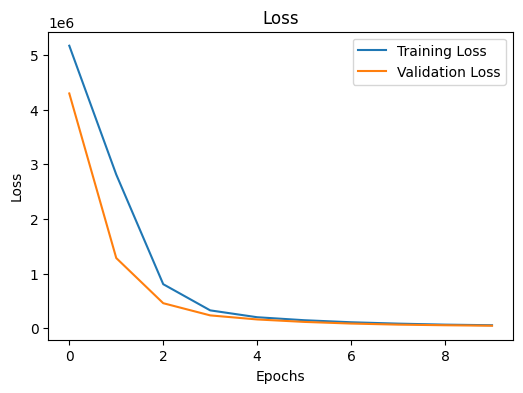

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(best_regressor['history'].history['loss'], label='Training Loss')
plt.plot(best_regressor['history'].history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()